In [2]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle

In [3]:
data=pd.read_csv(r"Medical_Claims_Data_1000_Model_Based_Status.csv")

# Data Preprocessing

In [4]:
# Create an "Age" column
current_year = datetime.now().year
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'], format='%d/%m/%Y')
data['Age'] = current_year - data['Date of Birth'].dt.year

In [5]:
data.head()

,Planholder Name,Patient Name,Membership Number,Date of Birth,Gender,Telephone Number,Medical Record Number,Provider Name,Provider Address,Medical Condition,...,Treatment Date,Type of Claim,Type of Condition,Type of Service,Admission Date,Discharge Date,Consultation Date,Symptom Onset Date,Claim Status,Age
0,Noah Rhodes,Angel Hill,E0IFD0TVBD,1997-07-26,Other,960-013-3890,NaN,Thompson-Le,"735 Jennifer Ridges, Margaretborough, IA 19946",Diabetes,...,14/09/2022,Accident,Acute,Out-Patient,NaN,NaN,31/08/2021,14/04/2021,Denied,27
1,Jerry Ramirez,Mike Miles,NMMJBQE7CK,1924-03-24,Male,001-265-423-5116x15594,W5NGCX1945NQ4FM,Lyons and Sons,"PSC 9920, Box 4573, APO AA 30057",Diabetes,...,14/08/2022,Illness,Congenital,Out-Patient,NaN,NaN,29/10/2021,30/03/2021,Denied,100
2,Jamie Arnold,Jessica Herrera,7XVG0FN9XU,1972-07-23,Other,001-310-341-3164,Y41IBLJH75LXO6Q,Miller-Bell,"08708 Paul Parks Apt. 823, Johnsontown, DE 20944",Asthma,...,09/03/2023,Injury,Chronic,In-Patient,22/07/2022,23/04/2023,18/09/2022,13/09/2022,Accepted,52
3,Michael Miles,Roy Martin,IUJV6OH9SD,1933-01-22,Male,+1-283-276-4835x030,BDW2PCN9T84AZYT,Orozco PLC,"176 Ferguson Green, Mendozamouth, WV 34927",Diabetes,...,15/08/2022,Illness,Chronic,Out-Patient,NaN,NaN,26/08/2021,15/10/2020,Denied,91
4,Latoya Robbins,Richard Jones,MKFAZZ81SD,1952-04-12,Other,+1-767-242-3884x9696,NaN,Hendrix and Sons,"801 King Drives, Annshire, VT 87664",Back pain,...,20/10/2023,Injury,Acute,Out-Patient,NaN,NaN,16/02/2022,21/09/2020,Denied,72


In [6]:
# Drop irrelevant columns
data.drop(columns=['Date of Birth','Telephone Number','Planholder Name', 'Patient Name', 'Membership Number', 'Medical Record Number', 'Provider Name', 'Provider Address', 'Treatment Date', 'Admission Date', 'Discharge Date', 'Consultation Date', 'Symptom Onset Date'], inplace=True)

# Handle missing values (if any)
data.dropna(inplace=True)

In [7]:
data

,Gender,Medical Condition,ICD 10 Code,Type of Claim,Type of Condition,Type of Service,Claim Status,Age
0,Other,Diabetes,E11,Accident,Acute,Out-Patient,Denied,27
1,Male,Diabetes,E11,Illness,Congenital,Out-Patient,Denied,100
2,Other,Asthma,J45,Injury,Chronic,In-Patient,Accepted,52
3,Male,Diabetes,E11,Illness,Chronic,Out-Patient,Denied,91
4,Other,Back pain,M54,Injury,Acute,Out-Patient,Denied,72
...,...,...,...,...,...,...,...,...
995,Other,Hypertension,I10,Illness,Acute,Out-Patient,Denied,87
996,Male,Diabetes,E11,Injury,Maternity,Day-Patient,Denied,77
997,Male,Hypertension,I10,Accident,Acute,Day-Patient,Denied,76
998,Other,Depression,F32,Illness,Congenital,In-Patient,Denied,98


In [8]:
# Encode categorical variables using label encoding
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [9]:
data

,Gender,Medical Condition,ICD 10 Code,Type of Claim,Type of Condition,Type of Service,Claim Status,Age
0,2,3,0,0,0,2,1,27
1,1,3,0,1,2,2,1,100
2,2,0,3,2,1,1,0,52
3,1,3,0,1,1,2,1,91
4,2,1,4,2,0,2,1,72
...,...,...,...,...,...,...,...,...
995,2,4,2,1,0,2,1,87
996,1,3,0,2,3,0,1,77
997,1,4,2,0,0,0,1,76
998,2,2,1,1,2,1,1,98


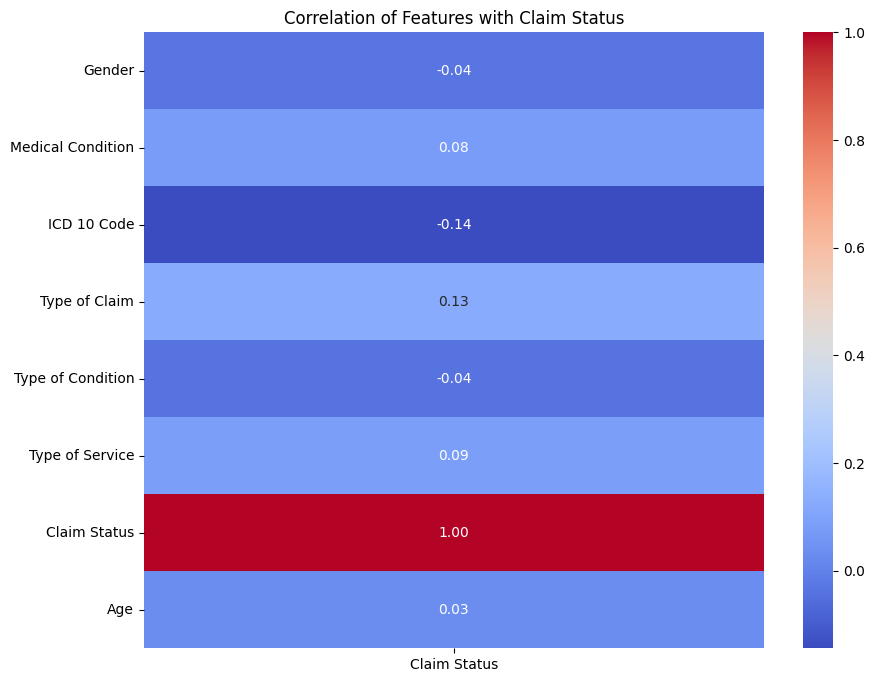

In [10]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Claim Status']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Claim Status")
plt.show()

In [11]:
# Split the dataset into features (X) and target variable (y)
X = data.drop(columns=['Claim Status'])
y = data['Claim Status']

In [12]:
# Model Training and Prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest Accuracy: 0.55


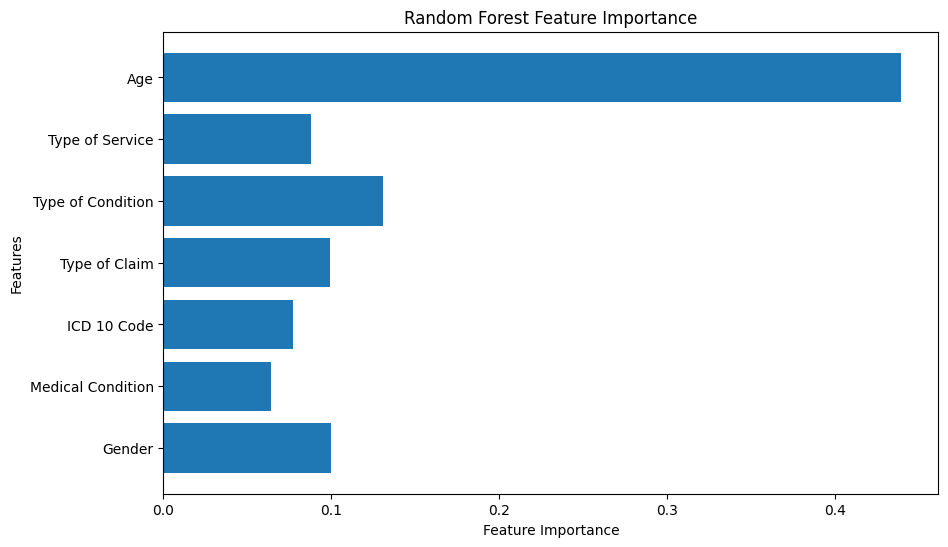

Logistic Regression Accuracy: 0.53


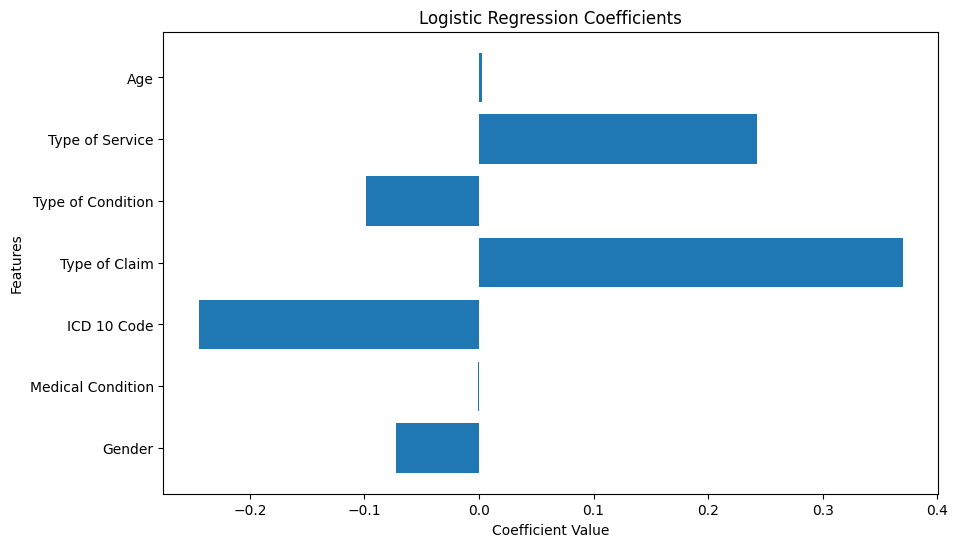

Naive Bayes Accuracy: 0.57
SVM Accuracy: 0.565
KNN Accuracy: 0.49
Decision Tree Accuracy: 0.595


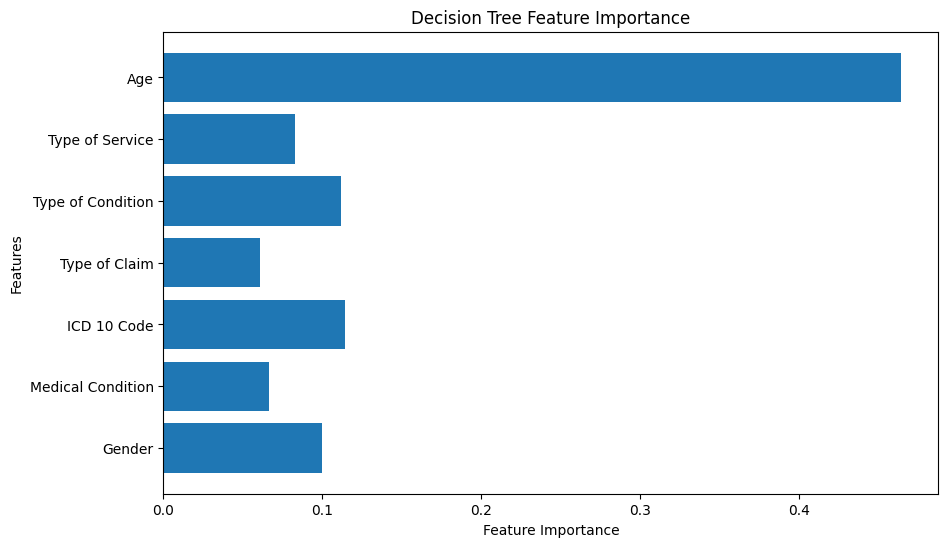

Gradient Boosting Accuracy: 0.605


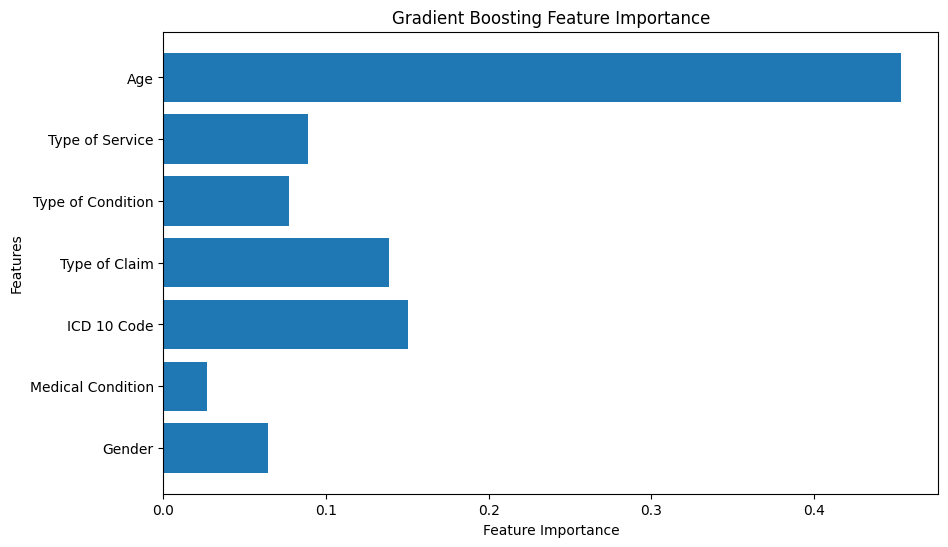

In [13]:
# Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    
    # Show feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, feature_importance)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'{name} Feature Importance')
        plt.show()
    # Show coefficients for logistic regression
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        feature_names = X.columns
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, coefficients)
        plt.xlabel('Coefficient Value')
        plt.ylabel('Features')
        plt.title(f'{name} Coefficients')
        plt.show()
    print("===================================================================================================================================")


# cross-validation

In [14]:
# # Models
# models = {
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'Logistic Regression': LogisticRegression(random_state=42),
#     'Naive Bayes': GaussianNB(),
#     'SVM': SVC(random_state=42),
#     'KNN': KNeighborsClassifier(),
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'Gradient Boosting': GradientBoostingClassifier(random_state=42)
# }

# # Train and evaluate each model using cross-validation
# for name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=5)
#     print(f"{name} Cross-Validation Mean Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
#     # Show feature importance
#     feature_importance = model.feature_importances_
#     feature_names = X.columns
#     plt.figure(figsize=(10, 6))
#     plt.barh(feature_names, feature_importance)
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Features')
#     plt.title('Random Forest Feature Importance')
#     plt.show()


## Shap

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.605


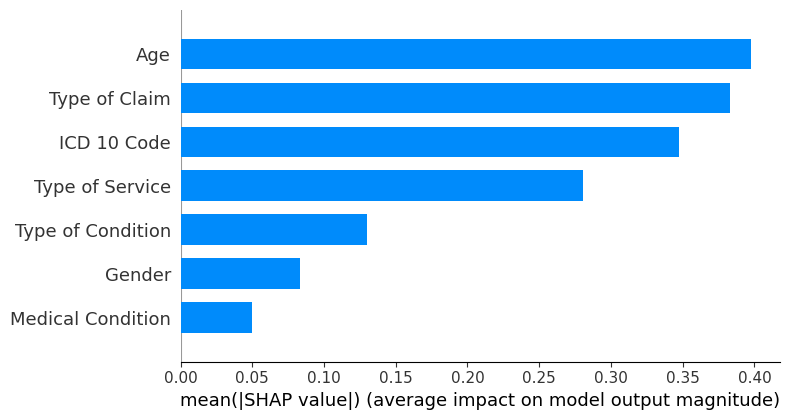

In [15]:
# Models
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")

    # Create an explainer object
    explainer = shap.Explainer(model)

    # Generate SHAP values
    shap_values = explainer.shap_values(X_test)
    
    # Plot SHAP values
    shap.summary_plot(shap_values, X_test, plot_type='bar', show=True)
    
    # # Create Explanation object for the first instance
    # explanation = shap.Explanation(shap_values[0][0], data=X_test.iloc[0])
    
    # # Set base values if not available
    # if explanation.base_values is None:
    #     explanation.base_values = 0.0  # You can set it to any default value you prefer
    
    # # Plot SHAP values as waterfall plot for the first instance
    # shap.plots.waterfall(explanation, show=True)
print("===================================================================================================================================")

In [16]:
model=LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"{name} Accuracy: {accuracy}")

# Dump (save) the decision tree model to a file
with open('gb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

Gradient Boosting Accuracy: 0.53
